In [1]:
import matplotlib.pyplot as plt
%matplotlib ipympl

In [2]:
import sys
sys.path.append('.')

In [3]:
import xarray as xr
# import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from hyperopt import fmin, hp, partial, tpe, Trials
import sys

sys.path.append('../..')
from pipeline.backtest import cross_validation
import pipeline.backtest_trading as bt

random_state = 42

base_ds = xr.open_dataset('../../data/nc_2round/base.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc_2round/fundamental_v0.nc')
market_ds = xr.open_dataset('../../data/nc_2round/market_brief.nc')

ds = xr.merge([base_ds, fundamental_v0_ds, market_ds])


In [47]:
# get the ohlc data from the ds
import math
ohlc = ds['close'].to_dataframe()
#In multiple index dataframe, get rows with asset index equal to 1
ohlc = ohlc.xs(53, level='asset')
a = ohlc.iloc[450:600, :]
b = a.shift(1)
intraday = (a - b) / a
z_score  = math.sqrt(len(a)) * intraday.mean() / intraday.std()
z_score



close    1.635236
dtype: float64

In [83]:
import math
import numpy as np
class PEPortfolio:
    def __init__(self):
        pass

    def initialize(self, X, y):
        pass

    def train(self, X, y):
        pass

    def construct(self, X):
        df = X.to_dataframe()
        intraday_signal = [0] * 54
        for i in range(54):
            a = df.xs(i, level='asset')
            b = a.shift(1)
            #get rid of the first row
            a = a.iloc[1:, :]
            b = b.iloc[1:, :]
            intraday = (a - b) / b
            z_score = (intraday.mean() / intraday.std()) * math.sqrt(len(a))
            if z_score.iloc[0] < -1.2:
                intraday_signal[i] = 1
        
        s = float(sum(intraday_signal))
    
        if s == 0:
            return np.array(intraday_signal)
        else:
            intraday_signal = [x / s for x in intraday_signal]
            intraday_signal_numpy = np.array(intraday_signal)
            return intraday_signal_numpy


In [84]:
pe_portfolio = PEPortfolio()
stat = bt.cross_validation(pe_portfolio, ['close'], ds, lookback_window=3, need_full_lookback=True)

  0%|          | 0/1700 [00:00<?, ?it/s]

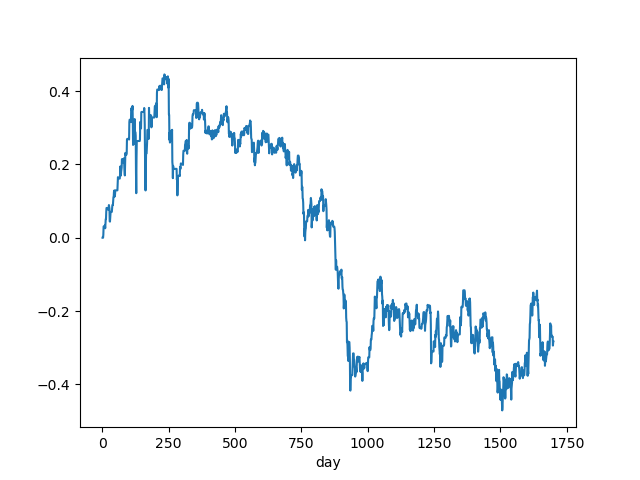

In [85]:
plt.figure()
np.log((stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).sum(dim='asset')+1).cumsum(dim='day').plot()
plt.show()